In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

import tensorflow as tf
import tensorflow_hub as hub

## Inserting file paths of training images into a dataframe

In [3]:
fake_files = os.listdir("D:\\KaggleML\\DEEPFAKE\\data\\train\\fake") 
real_files = os.listdir("D:\\KaggleML\\DEEPFAKE\\data\\train\\real")

fake_paths = ["D:\\KaggleML\\DEEPFAKE\\data\\train\\fake\\" + file for file in fake_files]
real_paths = ["D:\\KaggleML\\DEEPFAKE\\data\\train\\real\\" + file for file in real_files]
all_paths = fake_paths + real_paths

targets = []
targets += [1] * len(fake_paths)
targets += [0] * len(real_paths)

In [4]:
data = pd.DataFrame(columns=['id', 'target'])
data['id'] = all_paths
data['target'] = targets

In [5]:
np.random.seed(42)
data = data.sample(frac=1).reset_index(drop=True)

In [6]:
data

,id,target
0,D:\KaggleML\DEEPFAKE\data\train\real\train_rea...,0
1,D:\KaggleML\DEEPFAKE\data\train\fake\train_fak...,1
2,D:\KaggleML\DEEPFAKE\data\train\real\train_rea...,0
3,D:\KaggleML\DEEPFAKE\data\train\fake\train_fak...,1
4,D:\KaggleML\DEEPFAKE\data\train\real\train_rea...,0
...,...,...
11443,D:\KaggleML\DEEPFAKE\data\train\real\train_rea...,0
11444,D:\KaggleML\DEEPFAKE\data\train\fake\train_fak...,1
11445,D:\KaggleML\DEEPFAKE\data\train\fake\train_fak...,1
11446,D:\KaggleML\DEEPFAKE\data\train\fake\train_fak...,1


In [7]:
X = data['id']
Y = data['target']

In [8]:
NUM_IMAGES = 2000

In [9]:
np.random.seed(42)

x_train, x_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  Y[:NUM_IMAGES],
                                                  test_size = 0.2)
print(len(x_train), len(x_val), len(y_train), len(y_val))

1600 400 1600 400


In [10]:
image = imread(X[0])
image.shape # first image size

(112, 112, 3)

In [11]:
IMG_SIZE = 224 # required image size for the pretrained model

def process_image(filepath, img_size=IMG_SIZE):
  image = tf.io.read_file(filepath) #read the file to a tensor (long tensor string)
  image = tf.image.decode_jpeg(image, channels=3) #convert the file into a integer tensor
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) # normalize the data 
  image = tf.image.resize(image, size=(img_size, img_size)) # resize image to required resolution
  return image

def get_image_and_label(filepath, label): # helper function to get a pair of image and label tensors
  return process_image(filepath), label

In [12]:
get_image_and_label(X[41], Y[41])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.19596559, 0.1802793 , 0.18420087],
         [0.19375595, 0.17806967, 0.18199123],
         [0.18883055, 0.17314427, 0.17706583],
         ...,
         [0.0660014 , 0.04247199, 0.05031513],
         [0.0660014 , 0.04247199, 0.05031513],
         [0.0660014 , 0.04247199, 0.05031513]],
 
        [[0.19375595, 0.17806967, 0.18199123],
         [0.19215688, 0.1764706 , 0.18039216],
         [0.18883055, 0.17314427, 0.17706583],
         ...,
         [0.0627451 , 0.03921569, 0.04705883],
         [0.0627451 , 0.03921569, 0.04705883],
         [0.0627451 , 0.03921569, 0.04705883]],
 
        [[0.19215688, 0.1764706 , 0.18039216],
         [0.19046402, 0.17477773, 0.1786993 ],
         [0.18832566, 0.17263937, 0.17656094],
         ...,
         [0.0627451 , 0.03921569, 0.04705883],
         [0.0627451 , 0.03921569, 0.04705883],
         [0.0627451 , 0.03921569, 0.04705883]],
 
        ...,
 
        [[0.14184174, 0.12615547

In [13]:
BATCH_SIZE = 32

def create_batches(X, Y=None, batch_size=BATCH_SIZE, validation_data=False, test_data=False):

  '''
    Creates batches of data out of given image and label pairs.
    Shuffles data if its training data but doesn't if it is validation data.
    Accepts test data also with no output labels
  '''

  # given data is test data hence no labels
  if test_data:
    print('Creating test data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    # map image path tensor data to function which processes it into an image tensor
    return data_batch

  elif validation_data:
    print('Creating validation data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # file paths
                                               tf.constant(Y))) # labels

    data_batch = data.map(get_image_and_label).batch(BATCH_SIZE)
    # converts file path and label pair tensors into image and label
    # pair tensors and then into batches
    return data_batch

  else:
    print('Creating training data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y)))
    # shuffle data before mapping
    data = data.shuffle(buffer_size=len(data))
    data_batches = data.map(get_image_and_label).batch(BATCH_SIZE)
    return data_batches


In [14]:
train_data = create_batches(x_train, y_train, validation_data=False, test_data=False)
val_data = create_batches(x_val, y_val, validation_data=True, test_data=False)
train_data, val_data

Creating training data batches....
Creating validation data batches....


(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [15]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [16]:
def show_25_images(images, labels):
  plt.figure(figsize = ((10,10)))

  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    target = labels[i]
    if target == 1:
        text = "DeepFake"
    else:
        text = "Real"
    plt.title(text)
    plt.axis("off")

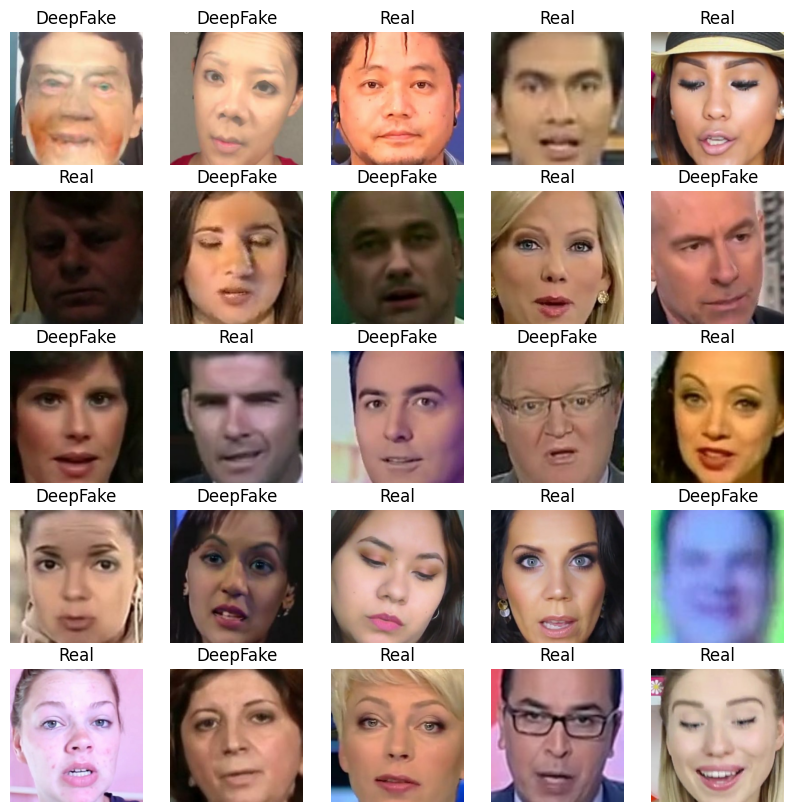

In [17]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

## Building the model

In [18]:
# Determine the input tensor shape
# Determine the output tensor shape
# URL of the model we are going to use

INPUT_SHAPE = (None, IMG_SIZE, IMG_SIZE, 3)

OUTPUT_SHAPE = 1 # binary output

MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2"

In [19]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building Model with', model_url)

  # setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url), # Layer 1 Input Layer
    tf.keras.layers.Dense(units=output_shape,
                          activation='sigmoid') # Layer 2 Output Layer. Sigmoid because of binary outcome
  ])

  # compile the model
  model.compile(
      loss=tf.keras.losses.binary_crossentropy,
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # build the model
  model.build(input_shape)

  return model


In [20]:
model = create_model()
model.summary()

Building Model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              21612360  
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 21,613,361
Trainable params: 1,001
Non-trainable params: 21,612,360
_________________________________________________________________


In [21]:
# Load tensorBoard notebook extension
%load_ext tensorboard

In [22]:
import datetime, os

# Creating a early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor="val_accuracy",
  patience=3
)

In [23]:
# decide the number of epochs
NUM_EPOCHS = 100

In [24]:
# A function that trains a model
def train_model():
  # Create a model with create_model function
  model = create_model()

  # fit the model by passing the data and callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            callbacks=[early_stopping],
            validation_data=val_data,
            validation_freq=1)

  return model

In [25]:
# model = train_model()

In [26]:
def save_model(model, suffix=None):
    model_dir = os.path.join('C:\\Users\\punee\\MLProjs\\DeepFake\\models',
                          datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S'))
    model_path = model_dir + '-' + suffix + '.h5'
    print('Saving the model to {}'.format(model_path))
    model.save(model_path)
    return model_path
    
def load_model(model_path):
    print('Loading the model from path: {}'.format(model_path))
    model = tf.keras.models.load_model(model_path,
                               custom_objects={'KerasLayer' : hub.KerasLayer})
    return model

In [27]:
model.evaluate(val_data)

13/13 [==============================] - 10s 133ms/step - loss: 1.0781 - accuracy: 0.4625


[1.0781464576721191, 0.4625000059604645]

In [28]:
val_preds = model.predict(val_data)
val_preds[:5]

13/13 [==============================] - 3s 129ms/step


array([[0.22779734],
       [0.05109623],
       [0.20624255],
       [0.11161182],
       [0.779135  ]], dtype=float32)

In [29]:
def unbatchify(val_data):
  images = []
  labels = []
  for image, label in val_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images, labels

In [30]:
val_images, val_labels = unbatchify(val_data)
train_images, train_labels = unbatchify(train_data)

In [31]:
def plot_pred(prediction_probs, val_images, val_labels, n=1): # val_labels are true labels

    prediction_prob, val_image, val_label = prediction_probs[n], val_images[n], val_labels[n] # get each value from arrays

    pred_label = 1 if prediction_prob > 0.5 else 0

    plt.imshow(val_image)

    plt.xticks([]) # remove axis markings
    plt.yticks([])

    if pred_label == val_label:
        c = "green"
    else:
        c = "red"

    plt.title('predicted = {}, activation = {:2.2f}%, actual = {}'.format(
        "deepfake" if pred_label == 1 else "real",
        np.max(prediction_prob) * 100,
        "deepfake" if val_label == 1 else "real"),
        color=c
    )
    

## Plotting predictions

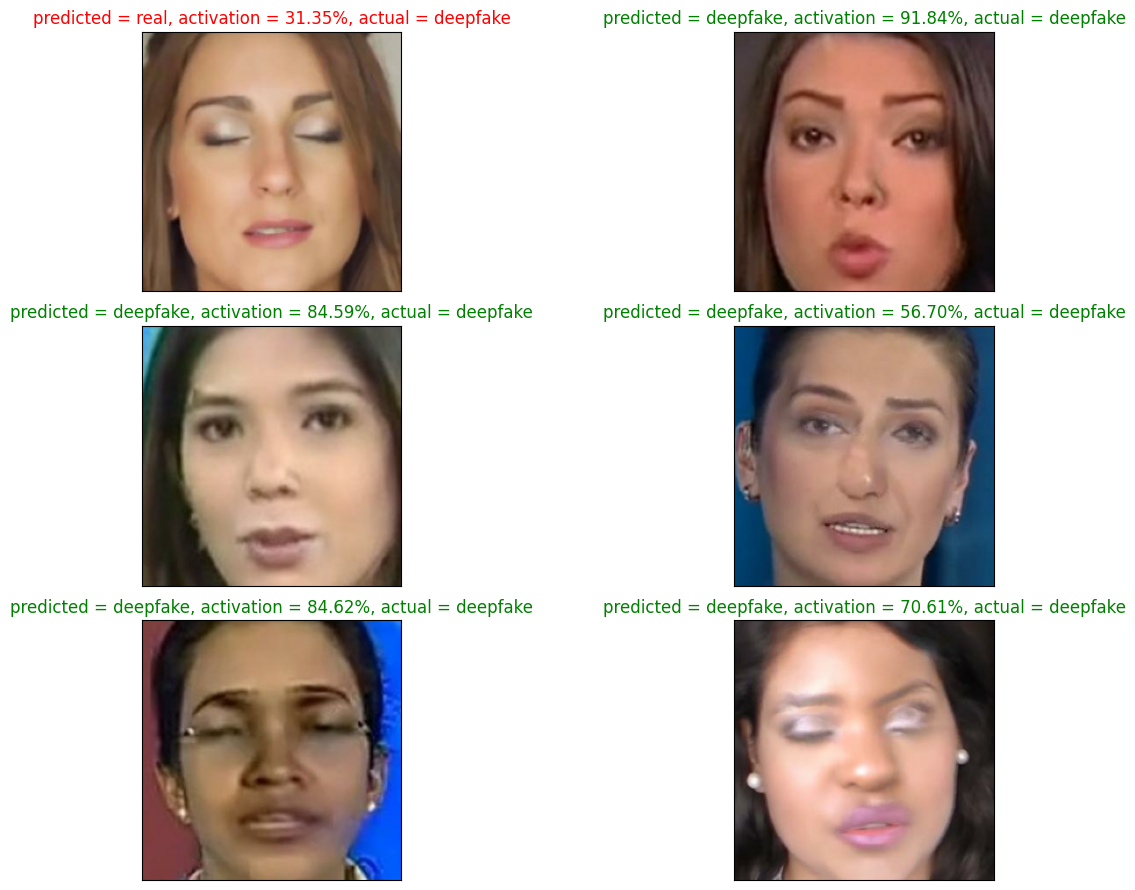

In [32]:
i_shift = 20
num_rows = 3
num_cols = 2
num_total = num_rows * num_cols
plt.figure(figsize=(6*num_cols, 3*num_rows))
for i in range(num_total):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_pred(val_preds, val_images, val_labels, n=i+i_shift)
plt.tight_layout(h_pad=1.0)

In [33]:
save_model(model, "2000-Images-EfficinetNetV2-Adam")

Saving the model to C:\Users\punee\MLProjs\DeepFake\models\24_04_2024_07_08_27-2000-Images-EfficinetNetV2-Adam.h5


'C:\\Users\\punee\\MLProjs\\DeepFake\\models\\24_04_2024_07_08_27-2000-Images-EfficinetNetV2-Adam.h5'

## Training on the entire dataset

In [32]:
full_data = create_batches(X, Y, batch_size=32)

Creating training data batches....


In [33]:
full_model = create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL)

Building Model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2


In [34]:
# creating callbacks
full_model_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=6)

In [35]:
history = full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_earlystopping])

Epoch 1/100
358/358 [==============================] - 61s 135ms/step - loss: 0.6099 - accuracy: 0.6734
Epoch 2/100
358/358 [==============================] - 51s 141ms/step - loss: 0.5279 - accuracy: 0.7376
Epoch 3/100
358/358 [==============================] - 53s 147ms/step - loss: 0.5074 - accuracy: 0.7493
Epoch 4/100
358/358 [==============================] - 53s 148ms/step - loss: 0.4923 - accuracy: 0.7615
Epoch 5/100
358/358 [==============================] - 54s 151ms/step - loss: 0.4831 - accuracy: 0.7693
Epoch 6/100
358/358 [==============================] - 55s 153ms/step - loss: 0.4804 - accuracy: 0.7740
Epoch 7/100
358/358 [==============================] - 56s 155ms/step - loss: 0.4745 - accuracy: 0.7726
Epoch 8/100
358/358 [==============================] - 56s 158ms/step - loss: 0.4707 - accuracy: 0.7772
Epoch 9/100
358/358 [==============================] - 57s 160ms/step - loss: 0.4665 - accuracy: 0.7791
Epoch 10/100
358/358 [==============================] - 58s 162m

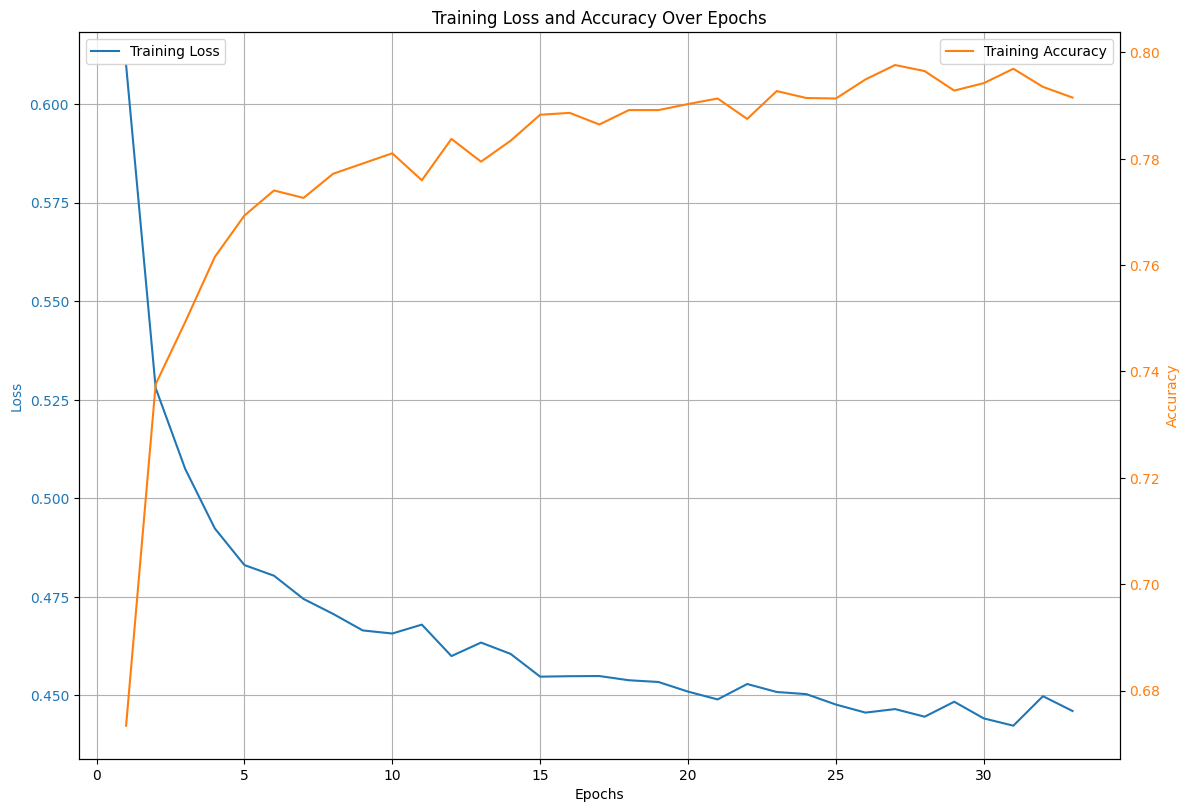

In [36]:
import matplotlib.pyplot as plt

# Assuming history.history contains 'loss', 'accuracy', and optionally 'val_loss', 'val_accuracy'
loss = history.history['loss']
accuracy = history.history['accuracy']

# Uncomment if you have validation data
# val_loss = history.history['val_loss']
# val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # Ensure the number of epochs matches your loss data

fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss, label='Training Loss', color=color)
# ax1.plot(epochs, val_loss, label='Validation Loss', linestyle='--', color=color)  # Uncomment if you have validation loss
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Accuracy', color=color)  # We already handled the x-label with ax1
ax2.plot(epochs, accuracy, label='Training Accuracy', color=color)
# ax2.plot(epochs, val_accuracy, label='Validation Accuracy', linestyle='--', color=color)  # Uncomment if you have validation accuracy
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # To make sure the labels do not overlap
plt.title('Training Loss and Accuracy Over Epochs')
plt.show()


In [ ]:
save_model(full_model, "All-Images-EfficinetNetV2-Adam-Plotting")

# Testing the Model

In [69]:
model = load_model("C:/Users/punee/MLProjs/DeepFake/models/24_04_2024_07_36_27-All-Images-EfficinetNetV2-Adam.h5")

Loading the model from path: C:/Users/punee/MLProjs/DeepFake/models/24_04_2024_07_36_27-All-Images-EfficinetNetV2-Adam.h5


In [70]:
fake_files = os.listdir("D:\\KaggleML\\DEEPFAKE\\data\\test\\fake") 
real_files = os.listdir("D:\\KaggleML\\DEEPFAKE\\data\\test\\real")

fake_paths = ["D:\\KaggleML\\DEEPFAKE\\data\\test\\fake\\" + file for file in fake_files]
real_paths = ["D:\\KaggleML\\DEEPFAKE\\data\\test\\real\\" + file for file in real_files]
all_paths = fake_paths + real_paths

targets = []
targets += [1] * len(fake_paths)
targets += [0] * len(real_paths)

In [71]:
data = pd.DataFrame(columns=['id', 'target'])
data['id'] = all_paths
data['target'] = targets

np.random.seed(42)
data = data.sample(frac=1).reset_index(drop=True)

In [72]:
data

,id,target
0,D:\KaggleML\DEEPFAKE\data\test\fake\test_fake ...,1
1,D:\KaggleML\DEEPFAKE\data\test\real\test_real ...,0
2,D:\KaggleML\DEEPFAKE\data\test\fake\test_fake ...,1
3,D:\KaggleML\DEEPFAKE\data\test\real\test_real ...,0
4,D:\KaggleML\DEEPFAKE\data\test\real\test_real ...,0
...,...,...
3100,D:\KaggleML\DEEPFAKE\data\test\real\test_real ...,0
3101,D:\KaggleML\DEEPFAKE\data\test\fake\test_fake ...,1
3102,D:\KaggleML\DEEPFAKE\data\test\fake\test_fake ...,1
3103,D:\KaggleML\DEEPFAKE\data\test\fake\test_fake ...,1


In [73]:
X, Y = data['id'], data['target']

In [74]:
test_data = create_batches(X, Y, test_data=True)

Creating test data batches....


In [75]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [159]:
y_preds = model.predict(test_data)

98/98 [==============================] - 13s 134ms/step


In [160]:
y_preds

array([[0.95137316],
       [0.13495241],
       [0.97751266],
       ...,
       [0.7245137 ],
       [0.85691726],
       [0.9069973 ]], dtype=float32)

In [161]:
y_preds.shape

(3105, 1)

In [162]:
y_final_preds = [1 if i >= 0.5 else 0 for i in y_preds]

In [ ]:
a = Y
b = y_final_preds

In [164]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [172]:
accuracy_score(a, b)

0.7909822866344606

In [173]:
y_final_preds = [1 if i >= 0.5 else 0 for i in y_preds]
print("Accuracy:", accuracy_score(a, b))
print("Confusion Matrix:", confusion_matrix(a, b))
print("Classification Report:", classification_report(a, b))
print("ROC AUC Score:", roc_auc_score(a, b))

Accuracy: 0.7909822866344606
Confusion Matrix: [[1148  414]
 [ 235 1308]]
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.73      0.78      1562
           1       0.76      0.85      0.80      1543

    accuracy                           0.79      3105
   macro avg       0.79      0.79      0.79      3105
weighted avg       0.80      0.79      0.79      3105

ROC AUC Score: 0.7913272363812285


In [174]:
true = a
pred = b

In [181]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [185]:
cnf_matrix = confusion_matrix(a, b)

In [188]:
from sklearn.metrics import ConfusionMatrixDisplay

In [186]:
cnf_matrix

array([[1148,  414],
       [ 235, 1308]], dtype=int64)

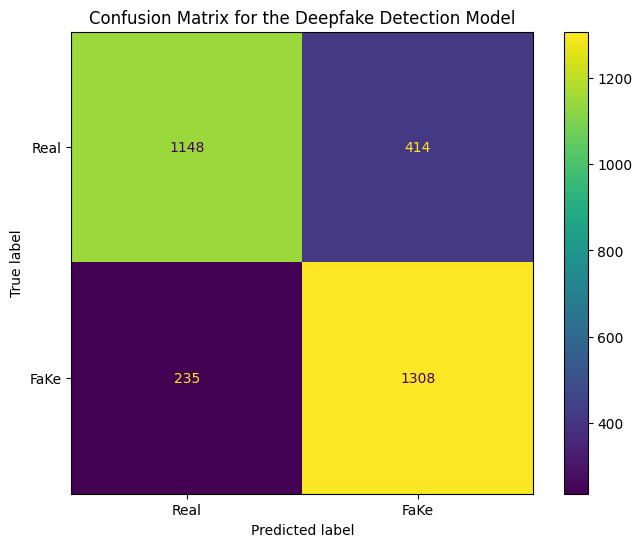

In [196]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
display = ConfusionMatrixDisplay(cnf_matrix, display_labels=["Real", "FaKe"])
 
ax.set(title='Confusion Matrix for the Deepfake Detection Model')
 
display.plot(ax=ax);